In [273]:
import pandas as pd
import numpy as np
import keras as k
import tensorflow as tf
import kerastuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
from focal_loss import BinaryFocalLoss
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, make_scorer, confusion_matrix

## My Goal/Notes/Ideas

To build a deep learning image classification model can identify pnemonia based on a set of X-ray images.

 - Type I error(FP): predict pnemonia but does not have it.
 - Type II error(FN): has pnemonia but predict no pnemonia.
 
Based on this I feel I should make lungs with pnemonia my target variables so these will be my Y-values.

I should also consider concentrating on accuracy or the F1 score.  Maybe try tweaking a model for each?

In [ ]:
!pip install git+https://github.com/artemmavrin/focal-loss.git

In [ ]:
!pip install -U imbalanced-learn

In [ ]:
!pip install -q -U keras-tuner

## Import data EDA

In [292]:
# Make Training Generator

train_gen = ImageDataGenerator(rescale=1./256)
generate_train = train_gen.flow_from_directory(directory=r'../data/train', seed=42,
                                    color_mode='grayscale',
                                    target_size=(64, 64), 
                                    batch_size=50, 
                                    class_mode='binary',
                                    interpolation='nearest')

from collections import Counter
counter = Counter(generate_train.classes)                          
max_val = float(max(counter.values()))       
train_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}  

# Make Val Generator

val_gen = ImageDataGenerator(rescale=1./256)
generate_val = val_gen.flow_from_directory(directory=r'../data/val', seed=42,
                                   color_mode='grayscale',
                                   target_size=(64,64),
                                   batch_size=48, 
                                   class_mode='binary',
                                   interpolation='nearest')


# Maket Test Generator

test_gen = ImageDataGenerator(rescale=1./256)
generate_test = test_gen.flow_from_directory(directory=r'../data/test', seed=42,
                                   color_mode='grayscale',
                                   target_size=(64,64),
                                   batch_size=50, 
                                   class_mode='binary',
                                   interpolation='nearest')


Found 5184 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [293]:
train_image, train_label = next(generate_train)
test_image, test_label = next(generate_test)
val_image, val_label = next(generate_val)

In [32]:
train_image.shape

(76, 4096)

In [33]:
train_label.shape

(76,)

In [ ]:
print(train_gen.dtype)
print(val_gen.dtype)
print(test_gen.dtype)

## Create FSM

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.2947 - accuracy: 0.20 - ETA: 0s - loss: 0.6400 - accuracy: 0.23 - 0s 31ms/step - loss: 0.5166 - accuracy: 0.2800 - val_loss: 0.1722 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.2892 - accuracy: 0.60 - ETA: 0s - loss: 0.2572 - accuracy: 0.70 - ETA: 0s - loss: 0.2171 - accuracy: 0.80 - 0s 19ms/step - loss: 0.2384 - accuracy: 0.7800 - val_loss: 0.1540 - val_accuracy: 0.7292
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 1.00 - ETA: 0s - loss: 0.2047 - accuracy: 0.64 - ETA: 0s - loss: 0.2049 - accuracy: 0.58 - 0s 16ms/step - loss: 0.2049 - accuracy: 0.5800 - val_loss: 0.1490 - val_accuracy: 0.6875
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.1081 - accuracy: 1.00 - ETA: 0s - loss: 0.1466 - accuracy: 0.86 - 0s 14ms/step - loss: 0.1652 - accuracy: 0.9000 - val_loss: 0.1386 - val_accuracy: 0.7500
Epoch 5/10
10/10

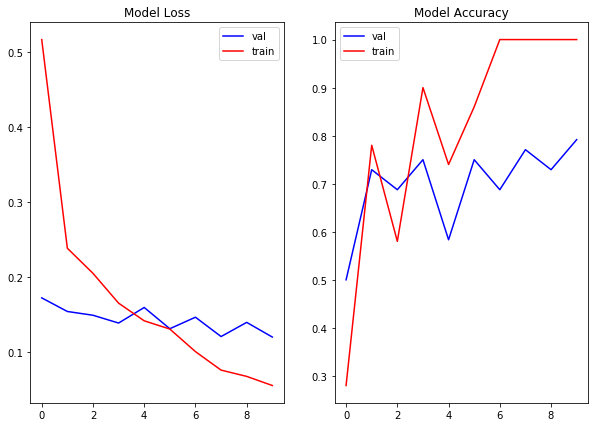

In [294]:
# USING A CNN MODEL!!!

train_image_inflate = []    
for i in range(len(train_image)):
    train_image_inflate.append(train_image[i].reshape(64,64,1))

train_image_inflate = np.array(train_image_inflate).reshape(50,64,64,1)

model = tf.keras.models.Sequential()

# Da'model
model.add(Conv2D(10, 3, activation='relu', input_shape=(64,64,1), padding='same'))
model.add(MaxPooling2D(2,2))
model.add(k.layers.Flatten())
model.add(Dense(units=1, activation='sigmoid'))

# Compiler layer
model.compile(optimizer='adam', 
              loss=BinaryFocalLoss(gamma=2), 
              metrics=['accuracy'])

# Fitting Da'model
results1 = model.fit(train_image_inflate, train_label, 
                  validation_data =(val_image, val_label), 
                  epochs=10, 
                  steps_per_epoch=10, 
                  class_weight=train_weights) 


In [ ]:
import os
len(os.listdir('../data/train/NORMAL'))

In [ ]:
import os
len(os.listdir('../data/train/PNEUMONIA/'))

In [ ]:
model.summary()

In [496]:
def plot_results(results):
    
    '''
    After running a model, plot the training and validation
    scores for both loss and accuracy.
    '''
    
    val_loss = results.history['val_loss']
    train_loss = results.history['loss']

    val_accuracy = results.history['val_accuracy']
    train_accuracy = results.history['accuracy']
    
    fig, ax = plt.subplots(1,2, figsize=(10,7))

    ax[0].plot(results.epoch, val_loss, c='b', label='val')
    ax[0].plot(results.epoch, train_loss, c='r', label='train')
    ax[0].legend()
    ax[0].set_title('Model Loss')

    ax[1].plot(results.epoch, val_accuracy, c='b', label='val')
    ax[1].plot(results.epoch, train_accuracy, c='r', label='train')
    ax[1].set_title('Model Accuracy')

    ax[1].legend()
    
#     plt.savefig('FinModel')

## Validating data from first model?

In [401]:
tf.random.set_seed(7)

train_image_inflate = []    
for i in range(len(train_image)):
    train_image_inflate.append(train_image[i].reshape(64,64,1))
train_image_inflate = np.array(train_image_inflate).reshape(50,64,64,1)

model = tf.keras.models.Sequential()

# Da'model
model.add(Conv2D(10, 3, activation='relu', input_shape=(64,64,1), padding='same'))
model.add(MaxPooling2D(2,2))

model.add(k.layers.Flatten())
model.add(Dense(units=1, activation='sigmoid'))

# Compiler layer
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Fitting Da'model
results1 = model.fit(train_image_inflate, train_label, 
           validation_data=(val_image, val_label),
           class_weight=train_weights,
           epochs=50, 
           steps_per_epoch=5)


Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 1.2637 - accuracy: 0.60 - ETA: 0s - loss: 1.1232 - accuracy: 0.38 - 0s 55ms/step - loss: 1.1232 - accuracy: 0.3800 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 1.0635 - accuracy: 0.70 - ETA: 0s - loss: 0.9733 - accuracy: 0.76 - 0s 46ms/step - loss: 0.9733 - accuracy: 0.7600 - val_loss: 0.7159 - val_accuracy: 0.5000
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 1.0978 - accuracy: 0.70 - ETA: 0s - loss: 0.8890 - accuracy: 0.82 - 0s 24ms/step - loss: 0.8890 - accuracy: 0.8200 - val_loss: 0.6476 - val_accuracy: 0.6250
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 0.8263 - accuracy: 0.60 - ETA: 0s - loss: 0.8215 - accuracy: 0.66 - 0s 22ms/step - loss: 0.8215 - accuracy: 0.6600 - val_loss: 0.6236 - val_accuracy: 0.7292
Epoch 5/50
5/5 [==============================] - ETA: 0s - loss: 0.7728 - accuracy: 0.90 - ETA: 0s - loss: 

Epoch 38/50
5/5 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 1.00 - ETA: 0s - loss: 0.0187 - accuracy: 1.00 - 0s 22ms/step - loss: 0.0187 - accuracy: 1.0000 - val_loss: 0.4929 - val_accuracy: 0.8125
Epoch 39/50
5/5 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 1.00 - ETA: 0s - loss: 0.0154 - accuracy: 1.00 - 0s 27ms/step - loss: 0.0172 - accuracy: 1.0000 - val_loss: 0.4933 - val_accuracy: 0.8125
Epoch 40/50
5/5 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 1.00 - ETA: 0s - loss: 0.0165 - accuracy: 1.00 - 0s 21ms/step - loss: 0.0165 - accuracy: 1.0000 - val_loss: 0.4706 - val_accuracy: 0.8125
Epoch 41/50
5/5 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 1.00 - 0s 18ms/step - loss: 0.0156 - accuracy: 1.0000 - val_loss: 0.4934 - val_accuracy: 0.8125
Epoch 42/50
5/5 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 1.00 - 0s 18ms/step - loss: 0.0147 - accuracy: 1.0000 - val_

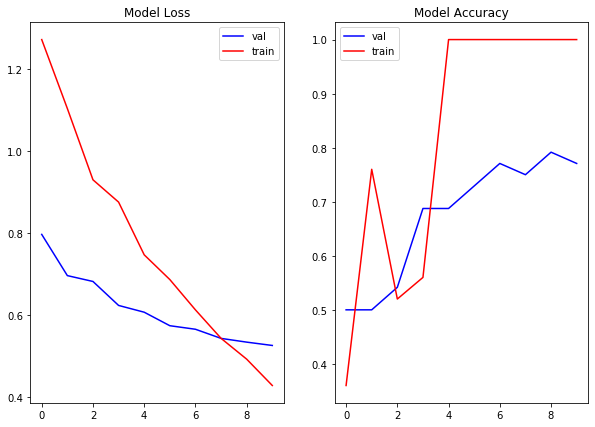

In [376]:
plot_results(results1)

In [402]:
model.evaluate(train_image, train_label)

2/2 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 1.00 - 0s 8ms/step - loss: 0.0068 - accuracy: 1.0000


[0.006816144101321697, 1.0]

In [403]:
model.evaluate(val_image, val_label)

2/2 [==============================] - ETA: 0s - loss: 0.4403 - accuracy: 0.81 - 0s 7ms/step - loss: 0.4840 - accuracy: 0.8125


[0.4840472638607025, 0.8125]

In [404]:
model.evaluate(test_image, test_label)

2/2 [==============================] - ETA: 0s - loss: 0.8655 - accuracy: 0.65 - 0s 7ms/step - loss: 0.6697 - accuracy: 0.7000


[0.6697333455085754, 0.699999988079071]

In [405]:
y_val_hat = model.predict_classes(val_image)

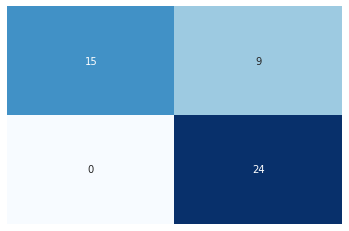

In [443]:
sns.heatmap(confusion_matrix(val_label, y_val_hat), annot=True, fmt='d',cmap='Blues', cbar=False,
           xticklabels=False, yticklabels=False,)



# plt.savefig('FSMconfusion')

### Results
The model functions! The accuracy score is in accurate for the first model where the accuracy is showing between 90 and 100 percent accuracy and a very low loss the cross validation showed an accuracy of 62 percent and a loss over 1.02 which shows the model need regularization and possibly some new layers.

### Second Model: adding layers

In [445]:
tf.random.set_seed(7)

train_image_inflate = []    
for i in range(len(train_image)):
    train_image_inflate.append(train_image[i].reshape(64,64,1))
train_image_inflate = np.array(train_image_inflate).reshape(50,64,64,1)

model2 = tf.keras.models.Sequential()

# Da'model
model2.add(Conv2D(10, 3, activation='relu', input_shape=(64,64,1), padding='same'))
model2.add(MaxPooling2D(2,2))

# Added newbie layers for this iteration; hope accuracy improves!
model2.add(Conv2D(15, 3, activation='relu', input_shape=(64,64,1), padding='same'))
model2.add(MaxPooling2D(2,2))

model2.add(Conv2D(20, 3, activation='relu', input_shape=(64,64,1), padding='same'))
model2.add(MaxPooling2D(2,2))

model2.add(Conv2D(25, 3, activation='relu', input_shape=(64,64,1), padding='same'))
model2.add(MaxPooling2D(2,2))

model2.add(Conv2D(30, 3, activation='relu', input_shape=(64,64,1), padding='same'))
model2.add(MaxPooling2D(2,2))

model2.add(k.layers.Flatten())
model2.add(Dense(units=25, activation='softmax', input_shape=(64,64,1)))
model2.add(Dense(units=1, activation='sigmoid'))

# Compiler layer
model2.compile(optimizer='adam', 
              loss=BinaryFocalLoss(gamma=2), 
              metrics=['accuracy'])

# Fitting Da'model
results2 = model2.fit(train_image, train_label, 
           validation_data=(val_image, val_label), 
           epochs=30,
           class_weight=train_weights,
           batch_size=10) 

Epoch 1/30
5/5 [==============================] - ETA: 0s - loss: 0.3268 - accuracy: 0.50 - ETA: 0s - loss: 0.2626 - accuracy: 0.26 - ETA: 0s - loss: 0.2548 - accuracy: 0.24 - 1s 102ms/step - loss: 0.2548 - accuracy: 0.2400 - val_loss: 0.1736 - val_accuracy: 0.5000
Epoch 2/30
5/5 [==============================] - ETA: 0s - loss: 0.2705 - accuracy: 0.30 - ETA: 0s - loss: 0.2518 - accuracy: 0.23 - ETA: 0s - loss: 0.2537 - accuracy: 0.24 - 0s 50ms/step - loss: 0.2537 - accuracy: 0.2400 - val_loss: 0.1734 - val_accuracy: 0.5000
Epoch 3/30
5/5 [==============================] - ETA: 0s - loss: 0.2711 - accuracy: 0.30 - ETA: 0s - loss: 0.2612 - accuracy: 0.26 - ETA: 0s - loss: 0.2532 - accuracy: 0.24 - 0s 50ms/step - loss: 0.2532 - accuracy: 0.2400 - val_loss: 0.1732 - val_accuracy: 0.5000
Epoch 4/30
5/5 [==============================] - ETA: 0s - loss: 0.2409 - accuracy: 0.20 - ETA: 0s - loss: 0.2306 - accuracy: 0.16 - ETA: 0s - loss: 0.2531 - accuracy: 0.24 - 0s 51ms/step - loss: 0.2531 

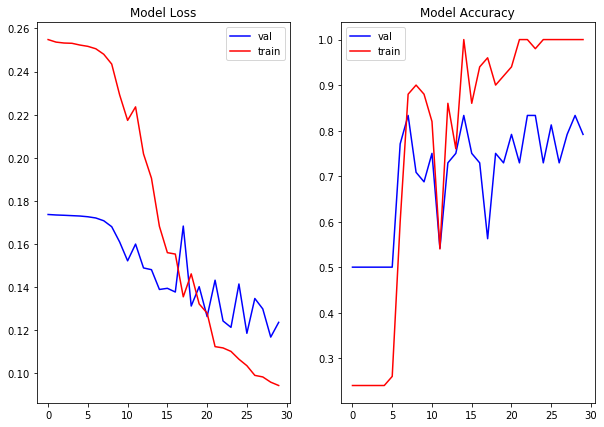

In [446]:
plot_results(results2)

In [447]:
model2.evaluate(val_image, val_label)

2/2 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.78 - 0s 11ms/step - loss: 0.1235 - accuracy: 0.7917


[0.1235276460647583, 0.7916666865348816]

In [448]:
model2.evaluate(test_image, test_label)

2/2 [==============================] - ETA: 0s - loss: 0.1385 - accuracy: 0.75 - 0s 9ms/step - loss: 0.1256 - accuracy: 0.8000


[0.12560254335403442, 0.800000011920929]

### Results
Adding two convolutional layers and one dense layer had no meaningful results.  Adding softmax activation on the first dense layer made the accuracy results more realistic in comparison to the evaluation results with the Val data.  Evaluating the model with the test data shows some good results but it's likely still due to overfitting.

## Third model: adding constraints

In [560]:
tf.random.set_seed(7)

train_image_inflate = []    
for i in range(len(train_image)):
    train_image_inflate.append(train_image[i].reshape(64,64,1))
train_image_inflate = np.array(train_image_inflate).reshape(50,64,64,1)

model3 = tf.keras.models.Sequential()

# Da'model
model3.add(Conv2D(30, 3, activation='tanh', input_shape=(64,64,1), padding='same',
                  activity_regularizer=regularizers.l2(.00001)))
model3.add(MaxPooling2D(2,2))

# Added Dropout layer
model3.add(Dropout(rate=.20))

model3.add(Conv2D(50, 3, activation='tanh', padding='same',
                  activity_regularizer=regularizers.l2(.00001)))                 
model3.add(MaxPooling2D(2,2))

model3.add(Conv2D(90, 3, activation='tanh', padding='same',
                  activity_regularizer=regularizers.l2(.0001)))                  
model3.add(MaxPooling2D(2,2))

model3.add(k.layers.Flatten())

model3.add(Dense(units=1, activation='sigmoid'))

# Compiling Layer
model3.compile(loss=BinaryFocalLoss(gamma=2),
               optimizer='Adam', 
               metrics=['accuracy'])
 
#Added early stopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-6, 
                           patience=3, verbose=0, mode='min')

# Fitting Da'model
results3 = model3.fit(train_image_inflate, train_label, 
                      epochs=100,
                      batch_size=10,
                      validation_data=(val_image, val_label),
                      class_weight=train_weights,                   
                      callbacks=[early_stop]) 


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.3754 - accuracy: 0.50 - ETA: 0s - loss: 0.6109 - accuracy: 0.30 - ETA: 0s - loss: 0.5375 - accuracy: 0.26 - ETA: 0s - loss: 0.4711 - accuracy: 0.25 - ETA: 0s - loss: 0.4287 - accuracy: 0.36 - 2s 334ms/step - loss: 0.4287 - accuracy: 0.3600 - val_loss: 0.2024 - val_accuracy: 0.5000
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.3157 - accuracy: 0.70 - ETA: 0s - loss: 0.2864 - accuracy: 0.75 - ETA: 0s - loss: 0.2792 - accuracy: 0.76 - ETA: 0s - loss: 0.2756 - accuracy: 0.77 - ETA: 0s - loss: 0.2769 - accuracy: 0.76 - 1s 231ms/step - loss: 0.2769 - accuracy: 0.7600 - val_loss: 0.2036 - val_accuracy: 0.5000
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.30 - ETA: 0s - loss: 0.2712 - accuracy: 0.25 - ETA: 0s - loss: 0.2778 - accuracy: 0.26 - ETA: 0s - loss: 0.2645 - accuracy: 0.25 - ETA: 0s - loss: 0.2691 - accuracy: 0.34 - 1s 238ms/step - loss: 0.2691 - accura

5/5 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 1.00 - ETA: 0s - loss: 0.0412 - accuracy: 0.95 - ETA: 0s - loss: 0.0365 - accuracy: 0.96 - ETA: 0s - loss: 0.0404 - accuracy: 0.97 - ETA: 0s - loss: 0.0399 - accuracy: 0.98 - 1s 243ms/step - loss: 0.0399 - accuracy: 0.9800 - val_loss: 0.1144 - val_accuracy: 0.8333


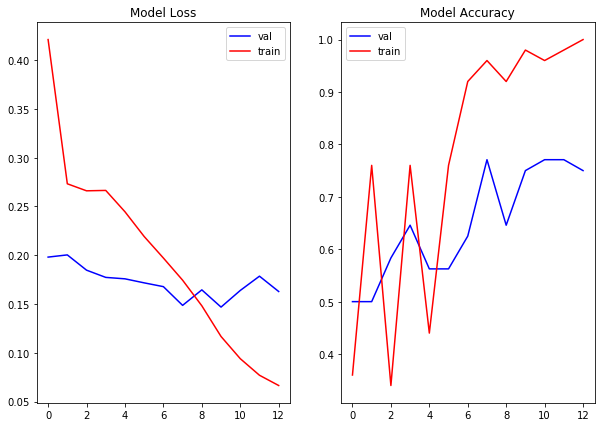

In [557]:
plot_results(results3)

In [558]:
model3.evaluate(val_image, val_label)

2/2 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.78 - ETA: 0s - loss: 0.1628 - accuracy: 0.75 - 0s 30ms/step - loss: 0.1628 - accuracy: 0.7500


[0.1628265231847763, 0.75]

In [559]:
model3.evaluate(test_image, test_label)

2/2 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 0.65 - ETA: 0s - loss: 0.1604 - accuracy: 0.74 - 0s 31ms/step - loss: 0.1604 - accuracy: 0.7400


[0.1604144126176834, 0.7400000095367432]

In [329]:
val_image.shape

(48, 64, 64, 1)

In [493]:
y_val_hat2 = model3.predict_classes(val_image)

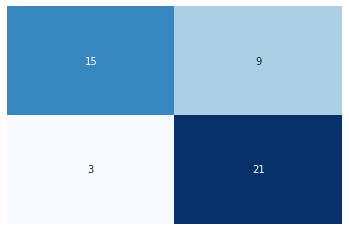

In [495]:
from sklearn.metrics import plot_confusion_matrix

sns.heatmap(confusion_matrix(val_label, y_val_hat2),cmap='Blues',annot=True, fmt='d',
            cbar=False, xticklabels=False, yticklabels=False);
plt.savefig('FinalMconfusion')

In [455]:
train_image.shape

(50, 64, 64, 1)

In [444]:
f1_score(val_label, y_val_hat2)

0.8214285714285714

In [454]:
val_image.shape

(48, 64, 64, 1)

## Trying SMOTE 

In [23]:
sm = SMOTE(random_state=42, sampling_strategy='minority')

train_image_rsz = []
for i in range(len(train_image)):
    train_image_rsz.append(train_image[i].reshape(1,-1))
    
train_image_rsz = np.array(train_image_rsz).reshape(50, 4096)

In [24]:

train_image, train_label = sm.fit_resample(train_image_rsz, train_label)

In [ ]:
train_image_rsz

In [41]:
model4 = tf.keras.models.Sequential()
 
train_image_inflate = []    
for i in range(len(train_image)):
    train_image_inflate.append(train_image[i].reshape(64,64,1))

train_image_inflate = np.array(train_image_inflate).reshape(76,64,64,1)

# Da'model
model4.add(Conv2D(10, 3, activation='relu', input_shape=(64,64,1), padding='same',
                  activity_regularizer=regularizers.l2(0.0002)))
model4.add(MaxPooling2D(2,2))

# Added Dropout layer
model4.add(Dropout(rate=.2))

model4.add(Conv2D(20, 3, activation='relu', input_shape=(64,64,1), padding='same',
                  activity_regularizer=regularizers.l2(0.0002)))
model4.add(MaxPooling2D(2,2))

model4.add(Conv2D(30, 3, activation='relu', input_shape=(64,64,1), padding='same',
                  activity_regularizer=regularizers.l2(0.0002)))
model4.add(MaxPooling2D(2,2))

model4.add(Conv2D(40, 3, activation='relu', input_shape=(64,64,1), padding='same',
                  activity_regularizer=regularizers.l2(0.0002)))
model4.add(MaxPooling2D(2,2))

model4.add(Conv2D(50, 3, activation='relu', input_shape=(64,64,1), padding='same',
                  activity_regularizer=regularizers.l2(0.0002)))
model4.add(MaxPooling2D(2,2))

model4.add(k.layers.Flatten())

model4.add(Dense(units=60, activation='relu', input_shape=(64,64,1)))
model4.add(Dense(units=1, activation='sigmoid'))

# Compiler layer W/ Stocastic Gradient Descent

# opt=k.optimizers.SGD(learning_rate=0.05)
model4.compile(loss=BinaryFocalLoss(gamma=2), 
               optimizer='adam', 
               metrics='accuracy')
 
#Added early stopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8, 
                           patience=2, verbose=1, mode='min')

# Fitting Da'model
model4.fit(train_image_inflate, train_label,
           validation_data=(val_image, val_label),
           epochs=50,
           batch_size=10,
           class_weight=train_weights,
           callbacks=[early_stop])
#            callbacks=[Metrics((val_image, val_label))])

Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 0.9190 - accuracy: 0.30 - ETA: 0s - loss: 0.8963 - accuracy: 0.40 - ETA: 0s - loss: 0.8272 - accuracy: 0.50 - ETA: 0s - loss: 0.8294 - accuracy: 0.47 - ETA: 0s - loss: 0.8109 - accuracy: 0.46 - ETA: 0s - loss: 0.7931 - accuracy: 0.45 - ETA: 0s - loss: 0.7698 - accuracy: 0.45 - ETA: 0s - loss: 0.7559 - accuracy: 0.44 - 1s 123ms/step - loss: 0.7559 - accuracy: 0.4474 - val_loss: 0.5212 - val_accuracy: 0.2500
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 0.6346 - accuracy: 0.70 - ETA: 0s - loss: 0.6213 - accuracy: 0.50 - ETA: 0s - loss: 0.6244 - accuracy: 0.56 - ETA: 0s - loss: 0.6232 - accuracy: 0.60 - ETA: 0s - loss: 0.6188 - accuracy: 0.60 - ETA: 0s - loss: 0.5999 - accuracy: 0.53 - ETA: 0s - loss: 0.5936 - accuracy: 0.48 - 1s 64ms/step - loss: 0.5960 - accuracy: 0.5000 - val_loss: 0.4410 - val_accuracy: 0.2500
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 0.5106 - accuracy: 0.60 -

In [40]:
model4.evaluate(test_image, test_label)

2/2 [==============================] - ETA: 0s - loss: 0.2397 - accuracy: 0.43 - 0s 11ms/step - loss: 0.2394 - accuracy: 0.4200


[0.23940163850784302, 0.41999998688697815]

In [ ]:
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class Metrics(Callback):
    
    def __init__(self, val_data):
        super().__init__()
        self.validation_data=val_data
        self.val_f1=None
        
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
 
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print ('- val_f1: %f — val_precision: %f — val_recall %f' %
        (_val_f1, _val_precision, _val_recall))
        return
    
    def on_train_end(self, logs={}):
        self.model.history.history['f1_score'] = self.val_f1s


In [ ]:
metrics = Metrics()